# Exploring word counts and outliers

The purpose of this notebook is to explore some summary statistics of the modern slavery statement dataset. In particular, we:
* Plot the propotion and company-industry origins of very short (<200 words) and long (>5000 words) statements
* Make a first attempt at distinguishing between two types of short statements: those which are the result of scraping errors, and those which are real statements, but just short
* Explore the word count distributions when the data is partitioned by two metrics:
   * industry
   * whether the statements were published in response to the UK Modern Slavery Act

## 1 Prerequisites
Ensure you can import the following packages, and have the file `modern_slavery_dataset.csv` downloaded in a subdirectory called `data` (i.e. you excecuted [this notebook](https://github.com/the-future-society/modern-slavery-statements-research/blob/master/notebooks/Tutorial%20-%20Download%20Modern%20Slavery%20Corpus.ipynb)).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
import pandas as pd
from tqdm import tqdm
from collections import OrderedDict
from itertools import combinations

In [2]:
df = pd.read_csv('data/modern_slavery_dataset.csv')

## 2 Data transformation

We'll iterate through the dataset and compute the summary statistcs we're interested in.

In [3]:
def detect_error(words):
    error_regex = '((.*)[Ee]rror(.*))|((.*)broken(.*))|((.*)[Oo]ps(.*))|((.*)[Ss]orry(.*))|((.*)404(.*))|((.*)[Ww]rong(.*))|((.*)[Ff]ound(.*))|((.*)[Pp]ermission(.*))|((.*)[Ee]xist(.*))' # TODO design a better regex that gives fewer false negatives
    if re.match(error_regex, words, re.DOTALL): # DOTALL makes the '.' special character match any character at all, including a newline; without this flag, '.' will match anything except a newline.
        return True

In [4]:
def update_short_count(df, i, shorts):
    shorts['count_total'] += 1
    industry = df['Industry'][i]
    company = df['Company'][i]
    shorts['industries'][industry] = shorts['industries'].get(industry, 0) + 1
    shorts['companies'].append(company)
    if detect_error(str(df['Text'][i])):
        shorts['count_error'] += 1

def update_long_count(df, i, longs): # TODO combine this and the previous function together
    longs['count_total'] += 1
    industry = df['Industry'][i]
    company = df['Company'][i]
    longs['industries'][industry] = longs['industries'].get(industry, 0) + 1
    longs['companies'].append(company)

In [5]:
shorts = {
    'count_total': 0, # total number of statements < 200 words ("short statements")
    'count_error': 0, # number of short statements that are scraping errors
    'industries': {}, # mapping from industry of short statements to their respective counts
    'companies': []   # list of companies with short statements
}
longs = {
    'count_total': 0, # total number of statements > 5000 words ("long statements")
    'industries': {}, # mapping from industry of short statements to their respective counts
    'companies': []   # list of companies with short statements
}
industries = {}
word_counts = {
    'total': [],
    'UK_modern_slavery_act_true': [],
    'rest': []
}
count_no_text_available = 0

for i in tqdm(range(len(df))):
    words = str(df['Text'][i]).split()
    if words == ['nan']:
        count_no_text_available += 1
    else:
        if len(words) < 200:
            update_short_count(df, i, shorts)
        elif len(words) > 5000:
            update_long_count(df, i, longs)
        industry = str(df['Industry'][i])
        industries[industry] = industries.get(industry, 0) + 1
        word_counts['total'].append(len(words))
        if df['UK Modern Slavery Act'][i] == True:
            word_counts['UK_modern_slavery_act_true'].append(len(words))
        else:
            word_counts['rest'].append(len(words))

100%|██████████| 28417/28417 [00:06<00:00, 4459.42it/s]


## 3 Data visualisation
Let's visualise the summary statistics that we computed.

Firstly, how many statements have text, and how many just contain `nan`?

In [6]:
count_text_available = len(df) - count_no_text_available
print('Out of the {} statements, {} have some text, and {} contain just `nan`'.format(
    len(df),
    count_text_available,
    count_no_text_available
))

Out of the 28417 statements, 18622 have some text, and 9795 contain just `nan`


### 3.1 How common are short and long statements?
Next, we'll look at the frequencies of the following different types of statements:

* short (<200 words)
* short, and due to a scraping error*
* long (>5000 words)
* the rest

\* NB I used a naive regex to identify these kinds of statements (see TODO above). There will be a lot of false negatives. Someone should think of a better regex that gets fewer false negatives (and few false positives too), and then recompute this.

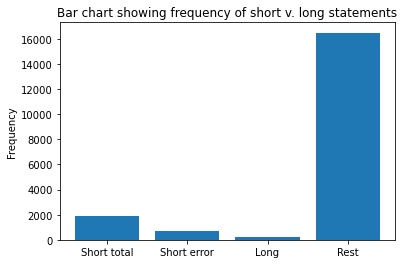

In [7]:
rest_count = count_text_available - shorts['count_total'] - longs['count_total']
x = np.arange(4)
counts = [shorts['count_total'], shorts['count_error'], longs['count_total'], rest_count]
labels = ['Short total', 'Short error', 'Long', 'Rest']
fig, ax = plt.subplots()
plt.bar(x, counts)
plt.xticks(x, labels)
ax.set_ylabel('Frequency')
ax.set_title('Bar chart showing frequency of short v. long statements')
plt.show()

### 3.2 Frequency of statements by industry
Next, let's check out the frequency of statements by industry. Nothing to do with word count here; we just want to see which industries have contributed relatively more statements.

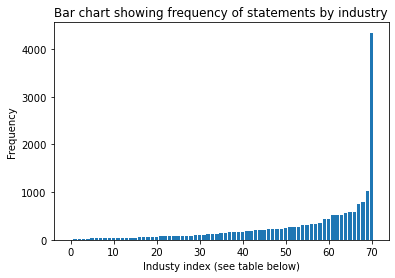

In [8]:
sorted_industries = OrderedDict(sorted(industries.items(), key=lambda x: x[1]))
x = np.arange(len(sorted_industries))
counts = list(sorted_industries.values())
labels = list(sorted_industries.keys())
fig, ax = plt.subplots()
# ax.yaxis.set_major_formatter(formatter)
plt.bar(x, counts)
ax.set_ylabel('Frequency')
ax.set_xlabel('Industy index (see table below)')
ax.set_title('Bar chart showing frequency of statements by industry')
plt.show()

Here's a table which maps index (on the x-axis of the chart) to industry. "Industry unknown" has the highest proportion of statements.

In [9]:
print('{:<5} | {:<5} | {}'.format('index', 'count', 'industry'))
for i, industry, count in zip(range(len(labels)), labels, counts):
    print('{:<5} | {:<5} | {}'.format(i, count, industry))

index | count | industry
0     | 1     | Mortgage Real Estate Investment Trusts (REITs)
1     | 14    | Health Care Technology
2     | 14    | Thrifts & Mortgage Finance
3     | 18    | Tobacco
4     | 23    | Wireless Telecommunication Services
5     | 30    | Biotechnology
6     | 31    | Multi-Utilities
7     | 32    | Life Sciences Tools & Services
8     | 33    | Equity Real Estate Investment Trusts (REITs)
9     | 34    | Gas Utilities
10    | 36    | Industrial Conglomerates
11    | 41    | Airlines
12    | 44    | Paper & Forest Products
13    | 47    | Multiline Retail
14    | 48    | Water Utilities
15    | 48    | Household Products
16    | 55    | Communications Equipment
17    | 62    | Leisure Products
18    | 66    | Containers & Packaging
19    | 69    | Independent Power and Renewable Electricity Producers
20    | 69    | Construction Materials
21    | 70    | Semiconductors & Semiconductor Equipment
22    | 70    | Personal Products
23    | 70    | Internet Software &

Let's see how the frequency of statements changes when only considering short and long statements.

#### Short statements

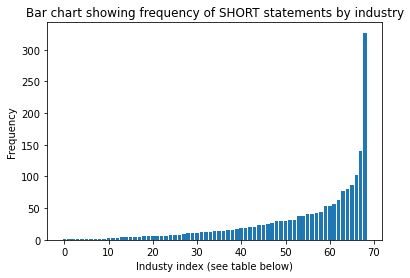

In [10]:
sorted_industries_short = OrderedDict(sorted(shorts['industries'].items(), key=lambda x: x[1]))
x = np.arange(len(sorted_industries_short))
counts_short = list(sorted_industries_short.values())
labels_short = list(sorted_industries_short.keys())
fig, ax = plt.subplots()
# ax.yaxis.set_major_formatter(formatter)
plt.bar(x, counts_short)
ax.set_ylabel('Frequency')
ax.set_xlabel('Industy index (see table below)')
ax.set_title('Bar chart showing frequency of SHORT statements by industry')
plt.show()

In [11]:
print('{:<5} | {:<5} | {}'.format('index', 'count', 'industry'))
for i, industry, count in zip(range(len(labels_short)), labels_short, counts_short):
    print('{:<5} | {:<5} | {}'.format(i, count, industry))

index | count | industry
0     | 1     | Paper & Forest Products
1     | 1     | Multi-Utilities
2     | 1     | Gas Utilities
3     | 1     | Transportation Infrastructure
4     | 1     | Health Care Technology
5     | 1     | Independent Power and Renewable Electricity Producers
6     | 1     | Thrifts & Mortgage Finance
7     | 1     | Wireless Telecommunication Services
8     | 2     | Life Sciences Tools & Services
9     | 2     | Industrial Conglomerates
10    | 3     | Tobacco
11    | 3     | Electric Utilities
12    | 3     | Consumer Finance
13    | 4     | Multiline Retail
14    | 4     | Diversified Telecommunication Services
15    | 5     | Biotechnology
16    | 5     | Household Products
17    | 5     | Automobiles
18    | 6     | Construction Materials
19    | 6     | Internet & Direct Marketing Retail
20    | 6     | Leisure Products
21    | 6     | Equity Real Estate Investment Trusts (REITs)
22    | 6     | Communications Equipment
23    | 6     | Marine
24    | 7     

#### Long statements

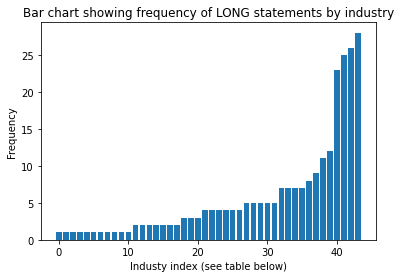

In [12]:
sorted_industries_long = OrderedDict(sorted(longs['industries'].items(), key=lambda x: x[1]))
x = np.arange(len(sorted_industries_long))
counts_long = list(sorted_industries_long.values())
labels_long = list(sorted_industries_long.keys())
fig, ax = plt.subplots()
# ax.yaxis.set_major_formatter(formatter)
plt.bar(x, counts_long)
ax.set_ylabel('Frequency')
ax.set_xlabel('Industy index (see table below)')
ax.set_title('Bar chart showing frequency of LONG statements by industry')
plt.show()

In [13]:
print('{:<5} | {:<5} | {}'.format('index', 'count', 'industry'))
for i, industry, count in zip(range(len(labels_long)), labels_long, counts_long):
    print('{:<5} | {:<5} | {}'.format(i, count, industry))

index | count | industry
0     | 1     | Technology Hardware, Storage & Peripherals
1     | 1     | Pharmaceuticals
2     | 1     | Insurance
3     | 1     | Household Durables
4     | 1     | Oil, Gas & Consumable Fuels
5     | 1     | Software
6     | 1     | Trading Companies & Distributors
7     | 1     | Household Products
8     | 1     | Independent Power and Renewable Electricity Producers
9     | 1     | Air Freight & Logistics
10    | 1     | Distributors
11    | 2     | Public Entities
12    | 2     | Beverages
13    | 2     | Health Care Equipment & Supplies
14    | 2     | Electronic Equipment, Instruments & Components
15    | 2     | Paper & Forest Products
16    | 2     | Road & Rail
17    | 2     | Banks
18    | 3     | Communications Equipment
19    | 3     | Hotels, Restaurants & Leisure
20    | 3     | Personal Products
21    | 4     | Commercial Services & Supplies
22    | 4     | Charity/Non-Profit
23    | 4     | Diversified Financial Services
24    | 4     | Const

### 3.3 UK v. rest
Finally, let's explore how the word count distributions change depending on whether the statements were published in response to the UK Modern Slavery Act.

First, how many statements are published in response to the UK Modern Slavery Act?

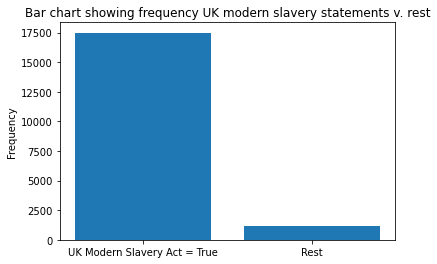

In [30]:
x = np.arange(2)
UK_counts = len(word_counts['UK_modern_slavery_act_true'])
rest_counts = len(word_counts['rest'])
counts = [UK_counts, rest_counts]
labels = ['UK Modern Slavery Act = True', 'Rest']
fig, ax = plt.subplots()
# ax.yaxis.set_major_formatter(formatter)
plt.bar(x, counts)
plt.xticks(x, labels)
ax.set_ylabel('Frequency')
ax.set_title('Bar chart showing frequency UK modern slavery statements v. rest')
plt.show()

In [26]:
print('So {:.0f}% of statements are UK statements'.format( 100 * UK_counts / (UK_counts+rest_counts)))

So 94% of statements are UK statements


An overwhelming majority!
So, how do the word count distributions change for this partitition?

Let's first plot the word counts over all statements as a histogram. We'll use a log scale on the x-axis to improve interpretability, because word counts vary over several orders of magnitude between documents.

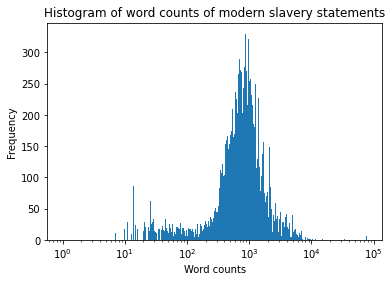

In [16]:
fig, ax = plt.subplots()
n, bins, patches = ax.hist(word_counts['total'], bins=np.logspace(0, np.log10(max(word_counts['total'])), 500))
ax.set_xlabel('Word counts')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of word counts of modern slavery statements')
ax.set_xscale('log')
plt.show()

In [17]:
count_between_400_2000 = sum(1 for count in word_counts['total'] if 400 <= count <= 2000)
print('{} statements have length between 400 and 2000 words, which is {:.0f}% of the total'.format(
    count_between_400_2000,
    count_between_400_2000 / len(word_counts['total']) * 100
))

13287 statements have length between 400 and 2000 words, which is 71% of the total


Now, how does this distribution change when considering our UK Modern Slavery Act partitition?

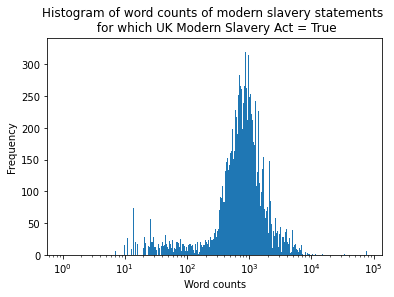

In [18]:
fig, ax = plt.subplots()
n, bins, patches = ax.hist(word_counts['UK_modern_slavery_act_true'], bins=np.logspace(0, np.log10(max(word_counts['UK_modern_slavery_act_true'])), 500))
ax.set_xlabel('Word counts')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of word counts of modern slavery statements \n for which UK Modern Slavery Act = True')
ax.set_xscale('log')
plt.show()

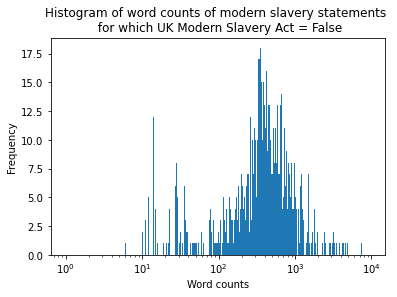

In [19]:
fig, ax = plt.subplots()
n, bins, patches = ax.hist(word_counts['rest'], bins=np.logspace(0, np.log10(max(word_counts['rest'])), 500))
ax.set_xlabel('Word counts')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of word counts of modern slavery statements \n for which UK Modern Slavery Act = False')
ax.set_xscale('log')
plt.show()

### 3.4 Identical statements
We don't expect any two statements to be identical. Identical statements almost certaintly indicate a scraping error. Let's find any identical statements.

In [20]:
print('Recall that there are {} statements excluding those which contain only \'nan\''.format(
    len([s for s in df['Text'] if not str(s) == 'nan'])
))

Recall that there are 18622 statements excluding those which contain only 'nan'


In [21]:
print('Of these statements, there are only {} unique statements'.format(
    len(set(df['Text']))
))

Of these statements, there are only 10026 unique statements


So there are quite a number of statements (approx 8000) which are identical to some other statement.